## Using pre-trained NN

In [37]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [87]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [88]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[9]

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [89]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img =np.flip(img, axis=2)
    

    #img = <substract mean>     WE DON'T NEED IT
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in xrange(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print np.linalg.norm(deprocess(preprocess(img)) - img)

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [90]:
net = build_model()

In [91]:
import pickle
with open('vgg16.pkl') as f:
    weights = pickle.load(f)

lasagne.layers.set_all_param_values(net['prob'],weights['param values'])
#all_weights=lasagne.layers.get_all_param_values(net['prob'])

In [92]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)
prob = theano.function([input_image], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

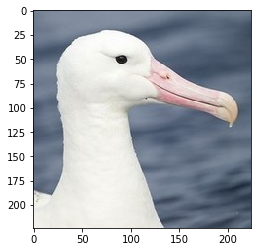

top-5 classes are:
0.999385	albatross
0.000613	goose
0.000001	American egret
0.000001	spoonbill
0.000000	pelican


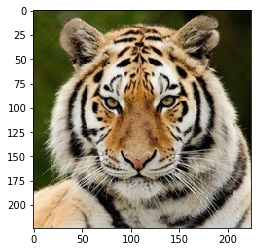

top-5 classes are:
0.813315	tiger
0.185448	tiger cat
0.000847	jaguar
0.000188	lynx
0.000123	leopard


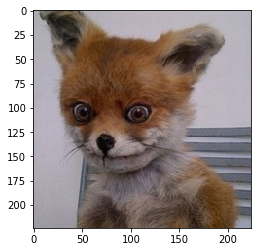

top-5 classes are:
0.426272	Pomeranian
0.158820	red fox
0.103022	Persian cat
0.091862	Chihuahua
0.040212	lynx


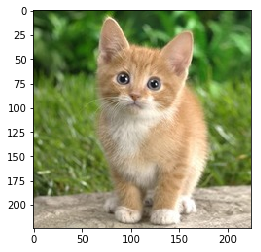

top-5 classes are:
0.439693	Egyptian cat
0.231661	tabby
0.147524	tiger cat
0.041370	lynx
0.026637	kit fox


In [96]:
for animal in ['albatross.jpg','tiger.jpg','fox.jpg','kitten.jpg']:
    img = imread(animal)
    plt.imshow(img)
    plt.show()

    p = prob(preprocess(img))

    labels = p.ravel().argsort()[-1:-6:-1]
    print 'top-5 classes are:'
    for l in labels:
        print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = <preprocess the image into features)
    Y.append(y)
    X.append(features)

In [ ]:

X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [ ]:
from sklearn.cross_validation import train_test_split

<split data either here or by cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print "I can do it!"